In [82]:
# core and utility packages
import pandas as pd
import numpy as np
import itertools

# visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import models

import os

np.random.seed(2)

In [83]:
os.getcwd()

'/home/Nickfis/Documents/Projects/digit_recognizer'

In [84]:
# Load the data
train = pd.read_csv("/home/Nickfis/Documents/Projects/digit_recognizer/data/train.csv")
test = pd.read_csv("/home/Nickfis/Documents/Projects/digit_recognizer/data/test.csv")

In [85]:
# checking structure of data
train.shape

(42000, 785)

In [86]:
#checking structure of data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

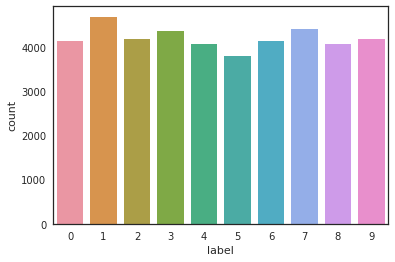

In [87]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Y_train)

# counting the occurrences of the labels. No imbalance problem. 
Y_train.value_counts()

In [88]:
# free some space
del train 

## Checking for Null and missing values

This would tell us about possible corrupted images in the dataset.

In [89]:
# Check the data
X_train.isnull().any().sum()
# no missing data in the training set

0

In [90]:
test.isnull().any().sum()
# no missing data in the testset

0

## Normalization
In context of computer vision, with normalization of data is meant here, to grayscale all the images. This is done on the one hand to reduce the effect of illumination's differences and has a big computational advantage, since now our feature space is just between 0 and 1, instead of ranging from 0 to 255.

In [91]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## Reshape

The dataset from Kaggle gives us a 784 feature vector for each of the images. This corresponds to the 28 pixel height and width of all the images. The following code will turn this array into a 3-dimensional array. Besides the height and width of an image we have to take care of its color (usually). Here the images are gray scaled instead of RGB. In case of a colored picture we would have 784x3 = 2352 features per image. 
In this case we will therefore have 42000 28x28x1 matrices in our training set.

In [92]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label encoding
One-hot encoding of target label. Instead of one number, which can take on values between 0 and 9, we will have a one-hot-vector for each observation with 10 dimensions.

## 2.6 Split training and validation set


In [94]:
# Set the random seed
random_seed = 2

In [95]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

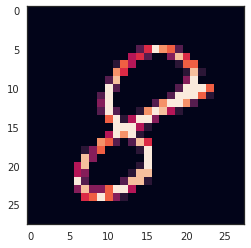

In [96]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

## Mdelling the convolutional neural network

In [97]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> [Dense -> Dropout]*2 -> Softmax
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 32)        4640      
__________

In [98]:
# Define the optimizer
optimizer = Adam(lr=1e-4)

In [99]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [100]:
# Set a learning rate annealer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# Turn epochs to 30 to get 0.9967 accuracy
epochs = 30 
batch_size = 86

## Data Augmentation


In [101]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

datagen.fit(X_train)

## Fitting the model

In [102]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[annealer])

ValueError: Error when checking target: expected dense_8 to have shape (10,) but got array with shape (1,)